## 1. Libraries

In [1]:
import sys
import os
import time
import tracemalloc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.abspath(os.path.join('..')))
from src.linear_regression_gd import LinearRegressionGD

## 2. Synthetic Data Generation

In [2]:
# Setup ----
# Simulate a dataset where P (Features) >> N (Samples)

n_samples = 5000
n_features = 20000   # High Dimensionality

print(f"Generating Synthetic Data: {n_samples} samples x {n_features} features...")
np.random.seed(6)

# X Matrix (Gene Expression Levels)
# Using standard normal distribution
X_high = np.random.randn(n_samples, n_features)

# True Weights (Simulating Biological Sparsity)
# In biology, usually only a small subset of genes drives the phenotype.
true_weights = np.zeros(n_features)
active_genes = np.random.choice(n_features, 500, replace=False) # Only 500 active genes
true_weights[active_genes] = np.random.uniform(-1, 1, 500)

# Target Y (Disease Score / Phenotype)
# Y = X * w + noise
y_high = np.dot(X_high, true_weights) + np.random.normal(0, 0.5, n_samples)

# Convert to DataFrame (Ensuring identical input format for both models)
df_X = pd.DataFrame(X_high, columns=[f'Gene_{i}' for i in range(n_features)])
s_y = pd.Series(y_high, name='Disease_Score')

print(f"Dataset Size in RAM: {df_X.memory_usage(deep=True).sum() / 1e6:.2f} MB")
print("-" * 60)

# List to store benchmark results
benchmark_results = []

Generating Synthetic Data: 5000 samples x 20000 features...
Dataset Size in RAM: 800.00 MB
------------------------------------------------------------


## 3. Benchmark run

In [3]:
# Scikit-Learn (OLS / SVD) ----
print("1. Training Scikit-Learn (Standard)...")

# Start tracking memory and time
tracemalloc.start()
start_time = time.time()

sklearn_model = LinearRegression()
sklearn_model.fit(df_X, s_y)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory() # Capture peak memory usage
tracemalloc.stop()

time_sk = end_time - start_time
mem_sk = peak / 1024 / 1024 # Convert Bytes to MB

print(f"   -> Time: {time_sk:.4f} s | Peak Memory: {mem_sk:.2f} MB")
benchmark_results.append({'Model': 'Scikit-Learn', 'Time (s)': time_sk, 'Memory (MB)': mem_sk})


# Custom Class ---
print("2. Training Custom Gradient Descent...")

tracemalloc.start()
start_time = time.time()

# Note: We set normalize=False here because np.random.randn generates data 
# that is already centered and scaled (Standard Normal Distribution).
# This avoids redundant computation, strictly testing the optimization algorithm.
custom_model = LinearRegressionGD(learning_rate=0.01, n_iterations=1000, normalize=False)
custom_model.fit(df_X, s_y)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

time_gd = end_time - start_time
mem_gd = peak / 1024 / 1024 # Convert Bytes to MB

print(f"   -> Time: {time_gd:.4f} s | Peak Memory: {mem_gd:.2f} MB")
benchmark_results.append({'Model': 'Gradient Descent', 'Time (s)': time_gd, 'Memory (MB)': mem_gd})

1. Training Scikit-Learn (Standard)...
   -> Time: 54.4423 s | Peak Memory: 1722.89 MB
2. Training Custom Gradient Descent...
   -> Time: 48.3394 s | Peak Memory: 1526.50 MB


## 4. Custom Model vs. Scikit-Learn


=== FINAL BENCHMARK TABLE ===
              Model  Time (s)  Memory (MB)
0      Scikit-Learn     54.44      1722.89
1  Gradient Descent     48.34      1526.50

=== EFFICIENCY ANALYSIS ===
🚀 SPEED: Custom Model was 1.13x FASTER.
💾 MEMORY: Custom Model used 1.13x LESS MEMORY.


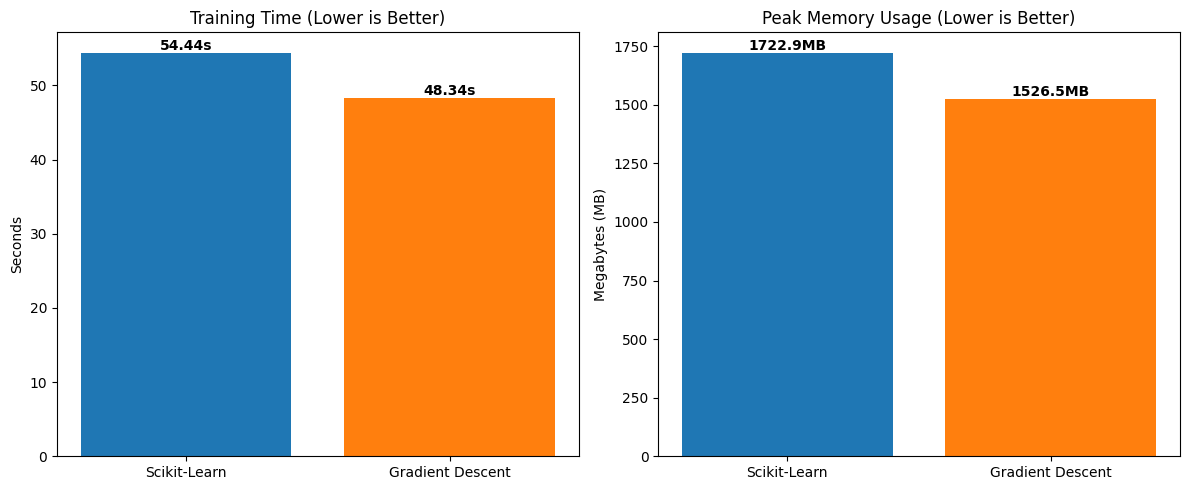

In [4]:
# Results ----
df_results = pd.DataFrame(benchmark_results)

print("\n=== FINAL BENCHMARK TABLE ===")
print(df_results.round(2))

print("\n=== EFFICIENCY ANALYSIS ===")

# Speed Comparison
if time_gd < time_sk:
    print(f"🚀 SPEED: Custom Model was {time_sk / time_gd:.2f}x FASTER.")
else:
    print(f"🐢 SPEED: Custom Model was {time_gd / time_sk:.2f}x slower (Expected due to Scikit-Learn's C++ backend).")

# Memory Comparison
if mem_gd < mem_sk:
    print(f"💾 MEMORY: Custom Model used {mem_sk / mem_gd:.2f}x LESS MEMORY.")
else:
    print(f"💾 MEMORY: Memory usage was similar.")


# Visualization ----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Training Time
ax1.bar(df_results['Model'], df_results['Time (s)'], color=['#1f77b4', '#ff7f0e'])
ax1.set_title('Training Time (Lower is Better)')
ax1.set_ylabel('Seconds')

# Add labels on top of bars
for i, v in enumerate(df_results['Time (s)']):
    ax1.text(i, v, f"{v:.2f}s", ha='center', va='bottom', fontweight='bold')

# Plot 2: Memory Usage
ax2.bar(df_results['Model'], df_results['Memory (MB)'], color=['#1f77b4', '#ff7f0e'])
ax2.set_title('Peak Memory Usage (Lower is Better)')
ax2.set_ylabel('Megabytes (MB)')

# Add labels on top of bars
for i, v in enumerate(df_results['Memory (MB)']):
    ax2.text(i, v, f"{v:.1f}MB", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Accuracy check


=== ACCURACY & SIGNAL RECOVERY CHECK ===
Scikit-Learn RMSE: 0.0000
Custom Model RMSE: 0.0000
----------------------------------------
Weight Recovery (Correlation with True Signal):
Scikit-Learn: 0.4963
Custom Model: 0.4963


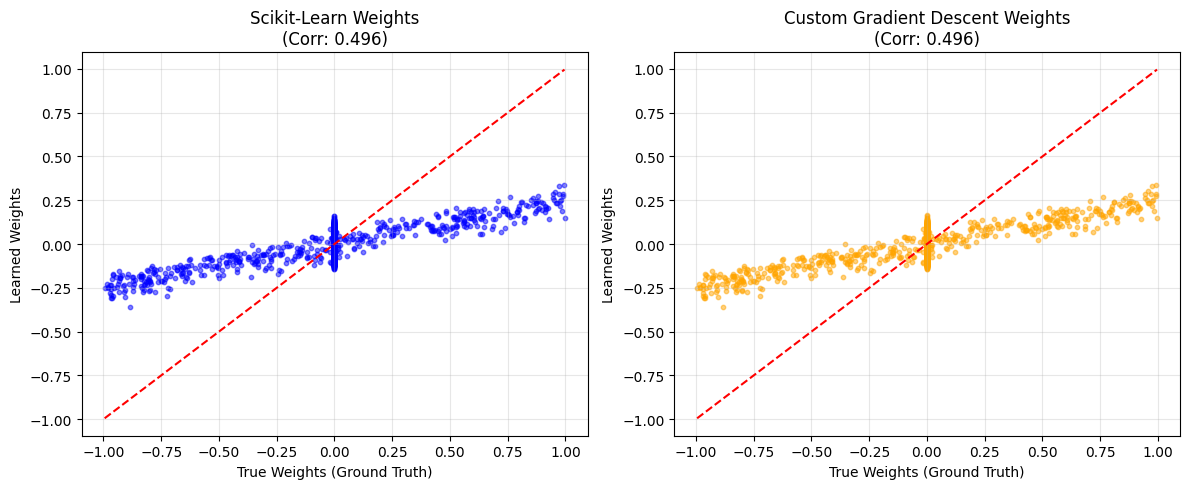

In [5]:
print("\n=== ACCURACY & SIGNAL RECOVERY CHECK ===")

# 1. Gerar Predições
preds_sk = sklearn_model.predict(df_X)
preds_gd = custom_model.predict(df_X)

# 2. Calcular RMSE (Root Mean Squared Error)
rmse_sk = np.sqrt(mean_squared_error(s_y, preds_sk))
rmse_gd = np.sqrt(mean_squared_error(s_y, preds_gd))

print(f"Scikit-Learn RMSE: {rmse_sk:.4f}")
print(f"Custom Model RMSE: {rmse_gd:.4f}")

# 3. Comparação dos Pesos (O teste "Biológico")
# Queremos saber: O modelo aprendeu os pesos REAIS que definimos no início?

# Extraindo pesos aprendidos
# Nota: Scikit-learn guarda em .coef_, nosso modelo em .weights
weights_sk = sklearn_model.coef_
weights_gd = custom_model.weights

# Correlação entre Pesos Reais e Pesos Aprendidos
# Se for perto de 1.0, o modelo "entendeu" a biologia por trás dos dados
corr_sk = np.corrcoef(true_weights, weights_sk)[0, 1]
corr_gd = np.corrcoef(true_weights, weights_gd)[0, 1]

print("-" * 40)
print(f"Weight Recovery (Correlation with True Signal):")
print(f"Scikit-Learn: {corr_sk:.4f}")
print(f"Custom Model: {corr_gd:.4f}")


# 4. Visualização: True Weights vs Learned Weights
plt.figure(figsize=(12, 5))

# Plot Scikit-Learn
plt.subplot(1, 2, 1)
plt.scatter(true_weights, weights_sk, alpha=0.5, s=10, color='blue')
plt.plot([min(true_weights), max(true_weights)], [min(true_weights), max(true_weights)], 'r--')
plt.title(f'Scikit-Learn Weights\n(Corr: {corr_sk:.3f})')
plt.xlabel('True Weights (Ground Truth)')
plt.ylabel('Learned Weights')
plt.grid(True, alpha=0.3)

# Plot Custom Model
plt.subplot(1, 2, 2)
plt.scatter(true_weights, weights_gd, alpha=0.5, s=10, color='orange')
plt.plot([min(true_weights), max(true_weights)], [min(true_weights), max(true_weights)], 'r--')
plt.title(f'Custom Gradient Descent Weights\n(Corr: {corr_gd:.3f})')
plt.xlabel('True Weights (Ground Truth)')
plt.ylabel('Learned Weights')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Final visualizations

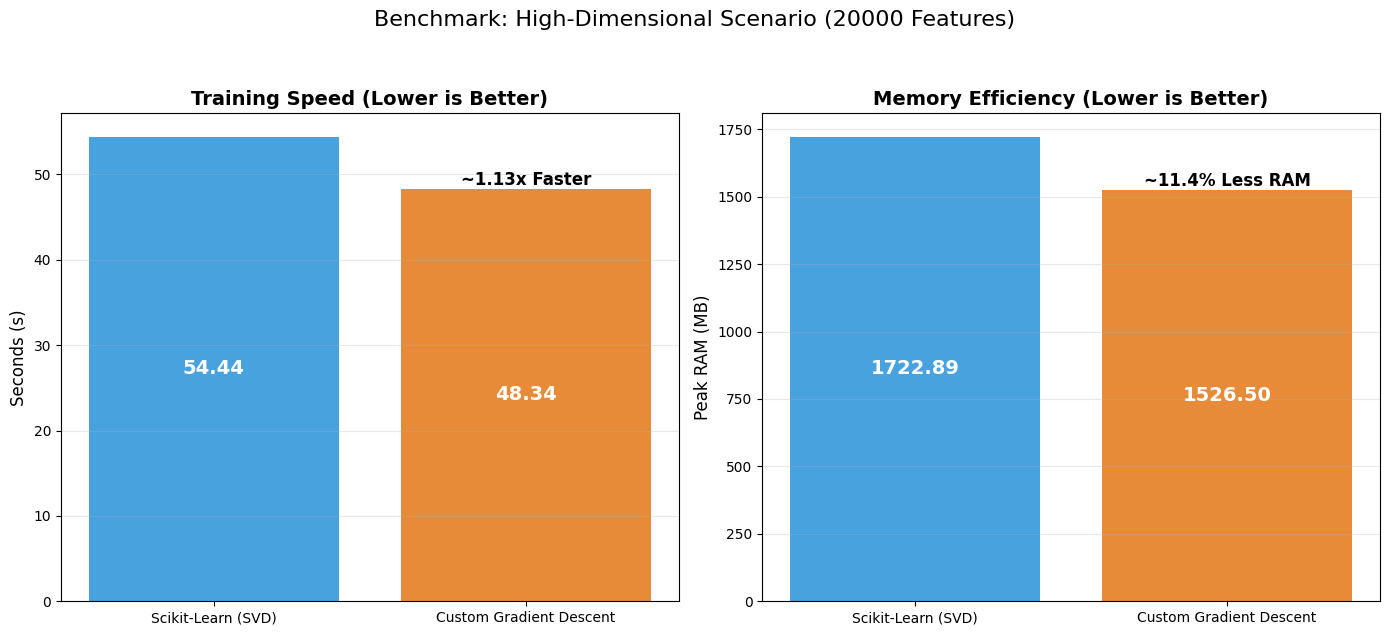

In [12]:
# Benchmark Data
models = ['Scikit-Learn (SVD)', 'Custom Gradient Descent']
times = [time_sk, time_gd]      
memories = [mem_sk, mem_gd]     

# Brand Colors
colors = ['#3498db', '#e67e22']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Training Speed ---
bars1 = ax1.bar(models, times, color=colors, alpha=0.9)
ax1.set_title('Training Speed (Lower is Better)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Seconds (s)', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Speed Annotation
speed_diff = times[0] / times[1]
if speed_diff > 1:
    ax1.text(1, times[1], f'~{speed_diff:.2f}x Faster', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Plot 2: RAM Usage ---
bars2 = ax2.bar(models, memories, color=colors, alpha=0.9)
ax2.set_title('Memory Efficiency (Lower is Better)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Peak RAM (MB)', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Memory Savings Annotation
mem_saved = 100 - (memories[1] / memories[0] * 100)
ax2.text(1, memories[1], f'~{mem_saved:.1f}% Less RAM', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Adding value labels inside bars
for ax, data in zip([ax1, ax2], [times, memories]):
    for i, v in enumerate(data):
        ax.text(i, v/2, f'{v:.2f}', ha='center', va='center', color='white', fontweight='bold', fontsize=14)

plt.suptitle(f'Benchmark: High-Dimensional Scenario ({n_features} Features)', fontsize=16, y=1.05)
plt.tight_layout()

# Saving to the parent directory's img folder
plt.savefig(os.path.join('..', 'img', 'scenario2_performance_benchmark.png'), dpi=300)
plt.show()